## Problem 2 - world cup

In [178]:
import pandas as pd
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

In [179]:
cd "~/Documents/EE/sem 1/DL/HWs/2"

/Users/alireza/Documents/EE/sem 1/DL/HWs/2


## Import data

In [180]:
df = pd.read_csv("international_matches.csv")
df[-10:]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


## Scatter plot

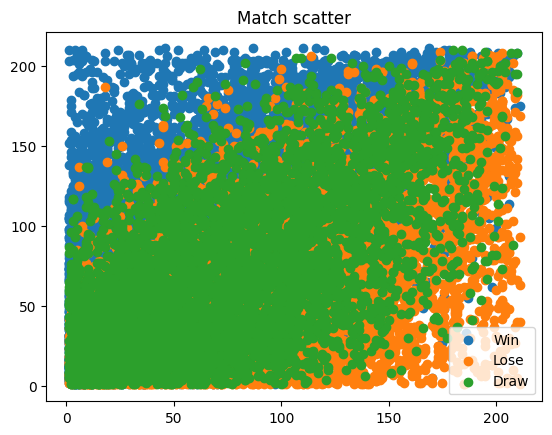

In [181]:

for s in ["Win", "Lose", "Draw"]:
    plt.scatter(
    df[df.home_team_result == s].loc[:, "home_team_fifa_rank"].to_numpy(),
        df[df.home_team_result == s].loc[:, "away_team_fifa_rank"].to_numpy(), label = s)
plt.legend()
plt.title("Match scatter")
plt.show()

## Correlation

<AxesSubplot: >

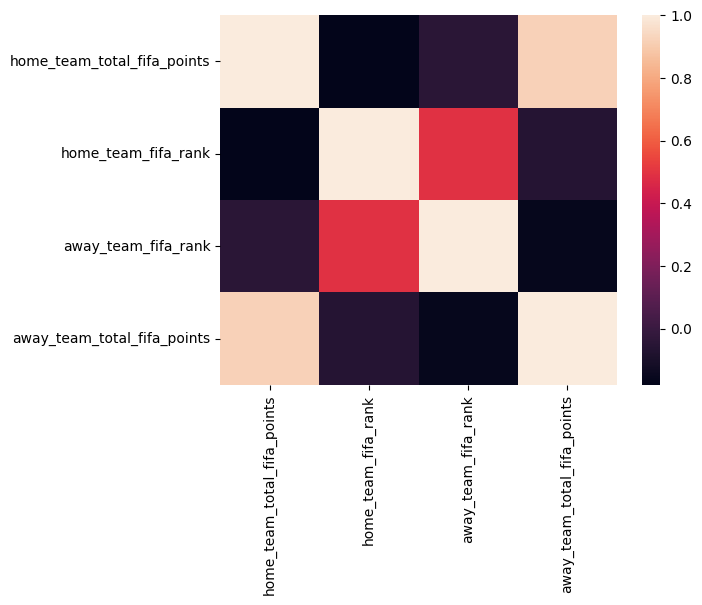

In [182]:
import seaborn as sns
from sklearn.utils import shuffle

## removing redundant data


df_shuf = shuffle(df)
df_shuf = df_shuf.drop(df.query("home_team_score==0 and away_team_score==0").index.to_numpy())

y = df_shuf["home_team_result"]

yf = np.zeros((len(df_shuf), 3))
for i in range(len(y)):
    if y.iloc[i] == "Win":
        yf[i,0] = 1
    elif y.iloc[i] == "Draw":
        yf[i,1] = 1
    elif y.iloc[i] == "Lose":
        yf[i,2] = 1
    else:
        print("erorr")

df_reduced = df_shuf[["home_team_total_fifa_points", "home_team_fifa_rank", "away_team_fifa_rank", 
         "away_team_total_fifa_points"]]

df_reduced = (df_reduced-df_reduced.mean())/df_reduced.std()

lt = int(len(df_reduced) * .75)
Xtrain, Xvalid = df_reduced[:lt], df_reduced[lt:]
ytrain, yvalid = yf[:lt], yf[lt:]

corr_map = df_reduced.corr('pearson')

sns.heatmap(corr_map)

## Network design

In [183]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 8)
        self.fc4 = nn.Linear(8, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)


In [184]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

Dtrain = TensorDataset( Tensor(Xtrain.to_numpy()), Tensor(ytrain) )
Dvalid = TensorDataset( Tensor(Xvalid.to_numpy()), Tensor(yvalid) )
trainloader = DataLoader(Dtrain, batch_size=16)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [185]:
epochs = 5


def trainNN(trainloader, Dvalid, net, epochs):
    
    for e in range(epochs):
        train_loss = 0.0
        for data, labels in trainloader:
            # Clear the gradients
            optimizer.zero_grad()
            # Forward Pass
            target = net(data)
            # Find the Loss
            loss = loss_criterion(target,labels.argmax(1))
            # Calculate gradients 
            loss.backward()
            # Update Weights
            optimizer.step()
            # Calculate Loss
            train_loss += loss.item()



        correct_valid = 0
        total_valid = 0

        correct_train = 0
        total_train = 0

        with tc.no_grad():
            for data in Dvalid:
                X, y = data
                output = net(X.view(-1,X.shape[0]))

                for idx, i in enumerate(output):
                    if tc.argmax(i) == np.argmax(y):
                        correct_valid += 1
                    total_valid += 1  

        with tc.no_grad():
            for data in Dtrain:
                X, y = data
                output = net(X.view(-1,X.shape[0]))
                for idx, i in enumerate(output):
                    if tc.argmax(i) == np.argmax(y):
                        correct_train += 1
                    total_train += 1

        
        print(f'Epoch {e+1} \t\t Training Loss: {round(train_loss / len(trainloader),4)}',
             "Train acc: %.2f, Test accuracy:  %.2f" % (correct_train/total_train, correct_valid/total_valid))
        
    


trainNN(trainloader, Dvalid, net, epochs)

Epoch 1 		 Training Loss: 0.8717 Train acc: 0.63, Test accuracy:  0.62
Epoch 2 		 Training Loss: 0.8598 Train acc: 0.63, Test accuracy:  0.62
Epoch 3 		 Training Loss: 0.859 Train acc: 0.63, Test accuracy:  0.62
Epoch 4 		 Training Loss: 0.8577 Train acc: 0.63, Test accuracy:  0.62
Epoch 5 		 Training Loss: 0.8569 Train acc: 0.63, Test accuracy:  0.62


## Tune network

In [186]:
continents = ["South America", "Africa", "Europe", "Asia", "North America", "Oceania"]

tournaments= []
for i in df_shuf.index:
    if df_shuf.loc[i].tournament not in tournaments:
        tournaments.append(df_shuf.loc[i].tournament)

df_modified = df_shuf[["home_team_total_fifa_points", "home_team_fifa_rank", "away_team_fifa_rank", "tournament",
         "away_team_total_fifa_points", "away_team_continent", "home_team_continent", "neutral_location"]]

for i in df_modified.index:
    df_modified.at[i,"away_team_continent"] = continents.index(df_modified.loc[i].away_team_continent)
    df_modified.at[i,"home_team_continent"] = continents.index(df_modified.loc[i].home_team_continent)
    df_modified.at[i,"tournament"] = tournaments.index(df_modified.loc[i].tournament)
    
    
M = df_modified.mean()
V = df_modified.std()
df_modified = (df_modified - M) / V

lt = int(len(df_modified) * .75)
Xtrain, Xvalid = df_modified[:lt], df_modified[lt:]

Dtrain = TensorDataset( Tensor(Xtrain.to_numpy(dtype='float')), Tensor(ytrain) )
Dvalid = TensorDataset( Tensor(Xvalid.to_numpy(dtype='float')), Tensor(yvalid) )
trainloader = DataLoader(Dtrain, batch_size=16,  shuffle=True)

df_modified[:10]

,home_team_total_fifa_points,home_team_fifa_rank,away_team_fifa_rank,tournament,away_team_total_fifa_points,away_team_continent,home_team_continent,neutral_location
21363,1.639260,0.840025,0.716330,-0.740111,1.703131,0.758569,0.728521,1.730049
5540,-0.646016,0.479306,-0.663572,-0.655902,-0.641602,1.575595,1.564262,1.730049
17324,0.713604,-0.792703,-1.465406,-0.571693,2.251118,-1.692512,-0.10722,-0.577992
22814,2.596766,-1.267333,-0.271978,-0.487484,2.130927,1.575595,1.564262,1.730049
18387,-0.110529,1.029877,1.741932,-0.403275,-0.413444,0.758569,0.728521,-0.577992
5819,-0.646016,-0.337058,-0.477098,-0.319066,-0.641602,-0.875485,-0.942961,-0.577992
13449,-0.646016,0.042646,-1.484054,-0.234857,-0.641602,-0.058458,-0.10722,-0.577992
11042,-0.646016,-0.735747,0.604446,-0.571693,-0.641602,-0.875485,-0.942961,-0.577992
17023,-0.214043,0.972921,0.529857,-0.571693,-0.063058,-0.875485,-0.942961,-0.577992
22030,2.497233,-1.153421,-1.390817,-0.150648,2.697249,-0.058458,-0.10722,-0.577992


In [187]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 20)
        self.fc4 = nn.Linear(20, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
net = Net()
print(net)

epochs = 5

optimizer = optim.Adam(net.parameters(), lr=0.02)
trainNN(trainloader, Dvalid, net, epochs)

Net(
  (fc1): Linear(in_features=8, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=3, bias=True)
)
Epoch 1 		 Training Loss: 0.8771 Train acc: 0.64, Test accuracy:  0.63
Epoch 2 		 Training Loss: 0.8644 Train acc: 0.63, Test accuracy:  0.63
Epoch 3 		 Training Loss: 0.8629 Train acc: 0.64, Test accuracy:  0.63
Epoch 4 		 Training Loss: 0.8607 Train acc: 0.62, Test accuracy:  0.61
Epoch 5 		 Training Loss: 0.8587 Train acc: 0.63, Test accuracy:  0.62


___
## Predicting IR's matches


We have to use the latest records to use their up-to-date data

In [188]:
## Create data
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

group = ["IR Iran", "USA", "Wales", "England"]

last_records = pd.DataFrame()
for team in group:
    for i in range(len(df)-1,0,-1):
        if df.iloc[i]["home_team"] == team:
            last_records = last_records.append(df.iloc[i])
            break


preData = pd.DataFrame()
for i in range(3):
    snap = last_records.iloc[0]
    snap.away_team_fifa_rank = last_records.iloc[i+1].home_team_fifa_rank
    snap.away_team = last_records.iloc[i+1].home_team
    snap.away_team_continent = continents.index(last_records.iloc[i+1].away_team_continent)
    snap.home_team_continent = continents.index(last_records.iloc[i+1].home_team_continent)
    snap.tournament = tournaments.index(last_records.iloc[i+1].tournament)
    snap.away_team_total_fifa_points = last_records.iloc[i+1].home_team_total_fifa_points
    snap.neutral_location = True
    preData = preData.append(snap)

print("\n Group data model (raw):")
display(preData)

preData_map = preData[["home_team_total_fifa_points", "home_team_fifa_rank", "away_team_fifa_rank", "tournament",
         "away_team_total_fifa_points", "away_team_continent", "home_team_continent", "neutral_location"]]

print("\n Group data model:")
display(preData_map)

preData_map = (preData_map - M)/ V

print("\n Group data tokenized:")
display(preData_map)

preData_map = Tensor(preData_map.to_numpy())


 Group data model (raw):


,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23875,2022-06-12,IR Iran,USA,4,4,21,15,1564,1633,1,...,No,Lose,73.0,78.0,69.0,75.3,69.0,78.0,81.0,78.0
23875,2022-06-12,IR Iran,Wales,2,2,21,18,1564,1588,1,...,No,Lose,73.0,78.0,69.0,75.3,69.0,78.0,81.0,78.0
23875,2022-06-12,IR Iran,England,2,2,21,5,1564,1761,1,...,No,Lose,73.0,78.0,69.0,75.3,69.0,78.0,81.0,78.0



 Group data model:


,home_team_total_fifa_points,home_team_fifa_rank,away_team_fifa_rank,tournament,away_team_total_fifa_points,away_team_continent,home_team_continent,neutral_location
23875,1564,21,15,9,1633,4,4,True
23875,1564,21,18,7,1588,2,2,True
23875,1564,21,5,7,1761,2,2,True



 Group data tokenized:


,home_team_total_fifa_points,home_team_fifa_rank,away_team_fifa_rank,tournament,away_team_total_fifa_points,away_team_continent,home_team_continent,neutral_location
23875,2.467373,-1.077481,-1.241638,0.017770,2.685026,1.575595,1.564262,1.730049
23875,2.467373,-1.077481,-1.185696,-0.150648,2.593355,-0.058458,-0.107220,1.730049
23875,2.467373,-1.077481,-1.428112,-0.150648,2.945778,-0.058458,-0.107220,1.730049


In [189]:
result = ["Win", "Lose", "Draw"]

count = 0
for data in preData_map:
    target= net(data.view(-1,data.shape[0]))
    print(preData.iloc[count].home_team, "vs.", preData.iloc[count].away_team, ":\t", result[target.argmax()], "\t", np.exp(target.max().detach().numpy()))
    count = count + 1

IR Iran vs. USA :	 Win 	 0.40894943
IR Iran vs. Wales :	 Win 	 0.40894943
IR Iran vs. England :	 Draw 	 0.47512737
